In [1]:
import os
import sys
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))
sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))

In [2]:
from pkg.global_config import RNB_PLANNING_DIR
from demo_utils.kiro_udp_send import start_mobile_udp_thread, send_pose_wait, get_xyzw_cur, get_reach_state
from pkg.utils.utils import *    
ip_cur =  get_ip_address()
MOBILE_IP = "192.168.0.102"
print("Current PC IP: {}".format(ip_cur))
print("Mobile ROB IP: {}".format(MOBILE_IP))

Current PC IP: 192.168.0.4
Mobile ROB IP: 192.168.0.102


In [8]:
sock, server_thread = start_mobile_udp_thread(recv_ip=ip_cur)
# tar_xyzw = (0,0,0,0)
# raise(NotImplementedError("tar_xyzw: relative? absolute?"))
# cur_xyzw = send_pose_wait(tar_xyzw, send_ip=MOBILE_IP)

Current PC IP: 192.168.0.123


In [3]:
# Directory setting
DEMO_DIR = os.path.join(RNB_PLANNING_DIR, "src/scripts/demo_202107")
CONFIG_DIR = os.path.join(DEMO_DIR, "configs")
SAVE_DIR = os.path.join(DEMO_DIR, "save_img")
CROP_DIR = os.path.join(DEMO_DIR, "crop_img")
MODEL_DIR = os.path.join(DEMO_DIR, "model_CAD")

# Table dimension
T_Width = 1.8
T_Height = 0.785
T_Depth = 0.734

In [4]:
from pkg.controller.combined_robot import *
from pkg.project_config import *
INDY_IP = "192.168.0.3"
crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, RobotType.indy7, None,
                INDY_IP, specs={"no_sdk":True})]
              , connection_list=[False])

connection command:
indy0: False


In [5]:
from pkg.geometry.builder.scene_builder import SceneBuilder
s_builder = SceneBuilder(None)
# s_builder.reset_reference_coord(ref_name="floor")

In [6]:
# xyz_rpy_robots = s_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
xyz_rpy_robots = {"indy0": ((0,0,0), (0,0,np.pi))}
crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)
gscene = s_builder.create_gscene(crob)

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]


In [7]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production


In [8]:
gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
gscene.set_workspace_boundary( -1.5, 1.5, -1, 1, -0.1, 1.75)

Please create a subscriber to the marker
   Use a production WSGI server instead.
 * Debug mode: off


## add env

In [9]:

# geometry 추가
mobile_base = gscene.create_safe(gtype=GEOTYPE.BOX, name="mobile_base", link_name="base_link", 
                   dims=(0.6,0.4,0.439), center=(0,0,-0.439/2), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)
floor = gscene.create_safe(gtype=GEOTYPE.BOX, name="floor", link_name="base_link", 
                   dims=(6,6,0.01), center=(0,0,-0.439), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

## add cam

In [10]:
for gtem in gscene:
    round_it_str(gtem.dims)
    round_it_str(gtem.center)

In [11]:
from pkg.geometry.geotype import GEOTYPE
gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="cam", link_name="indy0_tcp", 
                   dims=(0.061,0.061,0.026), center=(-0.0785,0,0.013), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="cam_col", link_name="indy0_tcp", 
                   dims=(0.081,0.081,0.046), center=(-0.0785,0,0.013), rpy=(0,0,0), 
                   color=(0.0,1,0,0.3), display=True, fixed=True, collision=True)

viewpoint = gscene.create_safe(gtype=GEOTYPE.SPHERE, name="viewpoint", link_name="indy0_tcp", 
                   dims=(0.01,0.01,0.01), center=(0,0,0), rpy=(0,0,-np.pi/2), 
                   color=(1,0,0,0.3), display=True, fixed=True, collision=False, parent="cam")

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="body", link_name="indy0_tcp", 
                   dims=(0.067,0.067,0.0335), center=(-0.0785,0,-0.01675), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,1), display=True, fixed=True, collision=False)

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="body_col", link_name="indy0_tcp", 
                   dims=(0.087,0.087,0.0535), center=(-0.0785,0,-0.01675), rpy=(0,0,0), 
                   color=(0.0,1,0,0.3), display=True, fixed=True, collision=True)

gscene.create_safe(gtype=GEOTYPE.SPHERE, name="backhead", link_name="indy0_tcp", 
                   dims=(0.067,0.067,0.067), center=(-0.0785,0,-0.0335), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,1), display=True, fixed=True, collision=False)

gscene.create_safe(gtype=GEOTYPE.SPHERE, name="backhead_col", link_name="indy0_tcp", 
                   dims=(0.087,0.087,0.087), center=(-0.0785,0,-0.0335), rpy=(0,0,0), 
                   color=(0.0,1,0,0.3), display=True, fixed=True, collision=True)

In [12]:
gscene.update_markers_all()

## add indy tool

In [13]:
gscene = gscene
robot_name="indy0"
face_name="brush_face"

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="{}_adapter".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0, 0, 0.0025), dims=(0.09, 0.09, 0.005), rpy=(0, 0, 0), color=(0.8, 0.8, 0.8, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="{}_adapter_col".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0, 0, 0.0025), dims=(0.13, 0.13, 0.005), rpy=(0, 0, 0), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)

gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_hindge0".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0, 0, 0.0125), dims=(0.022, 0.036, 0.025), rpy=(0, 0, 0), color=(0.8, 0.8, 0.8, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_hindge0_col".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0, 0, 0.0125), dims=(0.062, 0.076, 0.025), rpy=(0, 0, 0), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)

gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_bar".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.053, 0, 0.068), dims=(0.011, 0.020, 0.15), rpy=(0, 1*pi/4, 0), color=(0.8, 0.8, 0.8, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_bar_col".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.053, 0, 0.068), dims=(0.051, 0.060, 0.15), rpy=(0, 1*pi/4, 0), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)

gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_hindge1".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.1085,0,0.121), dims=(0.025, 0.036, 0.022), rpy=(0, 0, 0), color=(0.8, 0.8, 0.8, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_hindge1_col".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.1085,0,0.121), dims=(0.025, 0.076, 0.062), rpy=(0, 0, 0), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="{}_brushbase".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.1285,0,0.121), dims=(0.08, 0.08, 0.015), rpy=(0, pi/2, 0), color=(0.8, 0.8, 0.8, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="{}_brushbase_col".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.1285,0,0.121), dims=(0.12, 0.12, 0.015), rpy=(0, pi/2, 0), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)
gscene.create_safe(gtype=GEOTYPE.BOX, name=face_name, link_name="{}_tcp".format(robot_name),
                   center=(0.147,0,0.121), dims=(0.037, 0.10, 0.34), rpy=(np.pi, 0, pi), color=(1.0, 1.0, 0.94, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_col".format(face_name), link_name="{}_tcp".format(robot_name),
                   center=(0.127,0,0.121), dims=(0.057, 0.10, 0.36), rpy=(np.pi, 0, pi), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)

## Register binders

In [14]:
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepFramer, FixtureSlot
pscene.create_binder(bname="brush_face", gname="brush_face", _type=SweepFramer, point=(-gscene.NAME_DICT['brush_face'].dims[0]/2,0,0), 
                     rpy=(0,np.pi/2*1,0))

In [15]:
# Q = [0]*6
# viewpoint.draw_traj_coords([Q])
# gscene.show_pose(crob.home_pose)
# inspect_arguments(gscene.create_safe)
# gscene.add_highlight_axis("ax", "tcp", "indy0_tcp", center=(0,)*3, orientation_mat=np.identity(3))

## move indy to viewing pose

In [16]:
indy = crob.robot_dict["indy0"]

In [19]:
VIEW_POSE = np.deg2rad([  0., -28.,  85.,  -0.,  57., 179.])
if indy is not None:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(Qcur)

In [20]:
viewpoint.draw_traj_coords([Qcur])

[array([[ 7.09853221e-03, -4.06674659e-01,  9.13545473e-01,
          3.34360899e-01],
        [-9.99847710e-01, -1.74524058e-02,  1.63322856e-11,
          1.87870006e-01],
        [ 1.59435663e-02, -9.13406350e-01, -4.06736601e-01,
          8.61128940e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])]

In [20]:
# Start streaming & Save color, depth image
# Return is intrinsic parameter, depth_scale of camera
cam_intrins, d_scale = camera_streaming()

Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)


In [33]:
import SharedArray as sa
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

IMG_URI = "shm://color_img"
MASK_URI = "shm://mask_img"
REQ_URI = "shm://request"
RESP_URI = "shm://response"

color_img_p = sa.attach(IMG_URI)
return_img_p = sa.attach(MASK_URI)
request_p = sa.attach(REQ_URI)
resp_p = sa.attach(RESP_URI)

def detect_from_server(image):
    color_img_p[:] = image[:]
    request_p[:] = 1
    while not resp_p[0]:
        time.sleep(0.01)
    resp_p[:] = 0
    return np.copy(return_img_p.astype(np.bool))

In [34]:
# Set color, depth image path
# color_img_path = SAVE_DIR + '/color.jpg'
# depth_img_path = SAVE_DIR + '/depth.png'
color_img_path = DATASET_DIR + '/color.jpg'
depth_img_path = DATASET_DIR + '/depth.png'

# Read color, depth image file, keep 16bit information
color_img_read = cv2.imread(color_img_path, flags=cv2.IMREAD_UNCHANGED)
depth_img_read = cv2.imread(depth_img_path, flags=cv2.IMREAD_UNCHANGED)

In [35]:
# Output of inference(mask for detected table)
mask_out = detect_from_server(color_img_read)

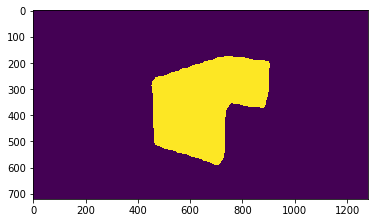

In [36]:
plt.imshow(mask_out)

In [37]:
# Crop masking part
vis_mask = (mask_out * 255).astype('uint8')
color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
cv2.imwrite(CROP_DIR + '/color_crop.jpg', color_instance)
cv2.imwrite(CROP_DIR + '/depth_crop.png', depth_instance)

True

In [38]:
import open3d as o3d
import numpy as np
import cv2
import copy
import os
import sys
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
#import subprocess
#subprocess.call(['python3', 'detection.py'])

In [39]:
def preprocessing():
    # Load CAD model of table leg
    model_mesh = o3d.io.read_triangle_mesh(MODEL_DIR + '/table_leg_scaling.STL')
    #model_pcd = model_mesh.sample_points_uniformly(number_of_points=300)

    # Load Depth image to make point clouds
    depth = o3d.io.read_image(CROP_DIR + '/depth_crop.png')
    depth_pcd = o3d.geometry.PointCloud.create_from_depth_image(depth,
                                            o3d.camera.PinholeCameraIntrinsic(cam_intrins.width,
                                            cam_intrins.height, cam_intrins.fx, cam_intrins.fy,
                                            cam_intrins.ppx, cam_intrins.ppy),
                                            depth_scale = 1/d_scale)
    #depth_pcd = o3d.geometry.PointCloud.create_from_depth_image(depth, o3d.camera.PinholeCameraIntrinsic(640, 480, 
    #                                                                                                  461.734375, 462.06640625, 
    #                                                                                                  350.4140625, 244.541015625), depth_scale = 4000.0)

    # Remove noise points which put very far from camera
    thres = np.linalg.norm(depth_pcd.get_center())
    depth_pcd = o3d.geometry.PointCloud.create_from_depth_image(depth,
                                            o3d.camera.PinholeCameraIntrinsic(cam_intrins.width,
                                            cam_intrins.height, cam_intrins.fx, cam_intrins.fy,
                                            cam_intrins.ppx, cam_intrins.ppy),
                                            depth_scale = 1/d_scale, depth_trunc = thres * 1.55)
    #depth_pcd = o3d.geometry.PointCloud.create_from_depth_image(depth, o3d.camera.PinholeCameraIntrinsic(640, 480, 
    #                                                                                                  461.734375, 462.06640625, 
    #                                                                                                  350.4140625, 244.541015625), depth_scale = 4000.0, depth_trunc = thres * 1.5)

    #o3d.visualization.draw_geometries([depth_pcd])

    # Convert point clouds to numpy array
    xyz_points = np.array(depth_pcd.points)

    # Kmeans Clustering to classify front, back legs of table
    # Ideally, if noise does not exist, then number of cluster is 2
    kmeans = KMeans(n_clusters = 2, random_state = 0)
    kmeans.fit(xyz_points)

    # Re-convert numpy array to point clouds in type of o3d point clouds
    pcd1 = o3d.geometry.PointCloud()
    pcd2 = o3d.geometry.PointCloud()
    #pcd3 = o3d.geometry.PointCloud()
    xyz_1 = np.vstack([xyz_points[kmeans.labels_ == 0,0], xyz_points[kmeans.labels_ == 0,1], xyz_points[kmeans.labels_ == 0,2]])
    xyz_2 = np.vstack([xyz_points[kmeans.labels_ == 1,0], xyz_points[kmeans.labels_ == 1,1], xyz_points[kmeans.labels_ == 1,2]])
    #xyz_3 = np.vstack([xyz_points[kmeans.labels_ == 2,0], xyz_points[kmeans.labels_ == 2,1], xyz_points[kmeans.labels_ == 2,2]])
    pcd1.points = o3d.utility.Vector3dVector(xyz_1.T)
    pcd2.points = o3d.utility.Vector3dVector(xyz_2.T)
    #pcd3.points = o3d.utility.Vector3dVector(xyz_3.T)
    FOR_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
    #o3d.visualization.draw_geometries([pcd1, FOR_origin])
    return model_mesh, pcd1, pcd2

In [40]:
def draw_registration_result_original_color(source, target, transformation):
    source_temp = copy.deepcopy(source)
    source_temp.transform(transformation)
    FOR_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
    
    FOR_model = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
    FOR_model.transform(transformation)
    FOR_model.translate(source_temp.get_center()-FOR_model.get_center())
    
    FOR_target = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=target.get_center())
    o3d.visualization.draw_geometries([source_temp, target, FOR_origin, FOR_model, FOR_target])

In [41]:
model_mesh, pcd1, pcd2 = preprocessing()

In [42]:
def compute_ICP(model_mesh, pcd):
    # Compute ICP to align model(source) to obtained point clouds(target)
    target = copy.deepcopy(pcd)
    model_pcd = model_mesh.sample_points_uniformly(number_of_points=int(len(np.array(target.points)*0.8)))
    source = copy.deepcopy(model_pcd)
    #source.translate((-T_Height/2, -T_Depth/2, 0.0), relative=True)
    source_cpy = copy.deepcopy(model_pcd)
    source_cpy.translate((-T_Height, -T_Depth, 0.0), relative=True)

    # Guess Initial Transformation
    center = target.get_center()
    trans_init = np.identity(4)
    trans_init[0:3,3] = center.T
    source_cpy.transform(trans_init)
    trans_init[0:3,3] = source_cpy.get_center().T
    draw_registration_result_original_color(source, target, trans_init)

    print("Apply point-to-point ICP")
    threshold = 0.12
    reg_p2p = o3d.registration.registration_icp(source, target, threshold, trans_init,
            o3d.registration.TransformationEstimationPointToPoint(),
            o3d.registration.ICPConvergenceCriteria(max_iteration = 600000))
    print(reg_p2p)
    print("Transformation is:")
    print(reg_p2p.transformation)
    draw_registration_result_original_color(source, target, reg_p2p.transformation)
    ICP_result = reg_p2p.transformation    
    return ICP_result   

In [43]:
ICP_result1 = compute_ICP(model_mesh, pcd1)
ICP_result2 = compute_ICP(model_mesh, pcd2)

FOR_1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
#FOR_1.translate((T_Height/2, T_Depth/2, 0.0), relative=True)
FOR_1.transform(ICP_result1)
#FOR_1.translate(source1.get_center()-FOR_1.get_center(), relative=True)
FOR_1.translate((T_Height/2, T_Depth/2, 0.0), relative=True)
#source1.transform(reg_p2p.transformation)

# FOR_2 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
# #FOR_2.translate((T_Height/2, T_Depth/2, 0), relative=True)
# FOR_2.transform(ICP_result2)
# #FOR_2.translate(source2.get_center()-FOR_2.get_center(), relative=True)
# FOR_2.translate((T_Height/2, T_Depth/2, 0), relative=True)
# #source2.transform(reg_p2p.transformation)center())

Apply point-to-point ICP
registration::RegistrationResult with fitness=6.473878e-01, inlier_rmse=2.967909e-02, and correspondence_set size of 10880
Access transformation to get result.
Transformation is:
[[ 0.87815442 -0.0042274   0.47835859 -0.48321984]
 [ 0.18776206  0.92276287 -0.33653246 -0.33759987]
 [-0.43998888  0.38534506  0.81112204  2.34534334]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=3.583101e-01, inlier_rmse=5.094119e-02, and correspondence_set size of 7082
Access transformation to get result.
Transformation is:
[[ 0.99237645  0.11887345  0.03252823 -0.56324732]
 [-0.09868193  0.92453784 -0.36809192 -0.01968898]
 [-0.07382993  0.36207581  0.92922024  2.48195064]
 [ 0.          0.          0.          1.        ]]


geometry::TriangleMesh with 1134 points and 2240 triangles.

# clustering 잘 안되는 문제 있음

In [44]:
TABLE_DIMS = np.array((0.785,1.80,0.735))
OFF_DIR = np.array([1,1,-1])

In [45]:
T_toff = SE3(Rot_axis(3,np.pi), np.divide(TABLE_DIMS[[0,1,2]]*OFF_DIR,2))
T_co = np.matmul(np.matmul(ICP_result1, SE3(Rot_axis(1, np.pi/2), [0]*3)), T_toff)
T_lo = np.matmul(viewpoint.Toff, T_co)
T_bc = viewpoint.get_tf(list2dict(Qcur, gscene.joint_names))
T_bo=np.matmul(T_bc, T_co)


### adjust height

In [46]:
T_bo[2,3] = TABLE_DIMS[2]/2

In [47]:
gscene.add_highlight_axis("table", "center", link_name="base_link", center=T_bo[:3,3], orientation_mat=T_bo[:3,:3])

# geometry 추가
table = gscene.create_safe(gtype=GEOTYPE.BOX, name="table", link_name="base_link", 
                   dims=TABLE_DIMS, center=T_bo[:3,3], rpy=Rot2rpy(T_bo[:3,:3]), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

In [48]:
# def ransac_plane_fitting(img_path):
#     # Find plane through ransac plane fitting
#     #depth_raw = o3d.io.read_image("/home/jhkim/Projects/rnb-planning/src/scripts/demo_202107/save_img/depth.png")
#     depth_raw = o3d.io.read_image(img_path)
#     depth_pcd_raw = o3d.geometry.PointCloud.create_from_depth_image(depth_raw,
#                                             o3d.camera.PinholeCameraIntrinsic(cam_intrins.width,
#                                             cam_intrins.height, cam_intrins.fx, cam_intrins.fy,
#                                             cam_intrins.ppx, cam_intrins.ppy), depth_scale = 1/d_scale)
#     #depth_pcd_raw = o3d.geometry.PointCloud.create_from_depth_image(depth_raw, o3d.camera.PinholeCameraIntrinsic(640, 480, 
#     #                                                                                                  461.734375, 462.06640625, 
#     #                                                                                                  350.4140625, 244.541015625), depth_scale = 4000.0)

#     plane_model, inliers = depth_pcd_raw.segment_plane(distance_threshold=0.01,
#                                              ransac_n=8,
#                                              num_iterations=2000)
#     [a, b, c, d] = plane_model
#     print("Coeffs of eq of fitting plane are :")
#     print(a,b,c,d)
#     return plane_model
#     #print(f"Plane equation: {a:.5f}x + {b:.5f}y + {c:.5f}z + {d:.5f} = 0")

In [49]:
# img_path = SAVE_DIR +'/depth.png'
# plane_est = ransac_plane_fitting(img_path)

In [50]:
# def first_pose_obj(FOR_1, FOR_2, plane_model):
#     # Estimated Translation of table from camera coordinate
#     model_center = (FOR_1.get_center() + FOR_2.get_center())/2
#     FOR_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
#     FOR_obj = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
#     FOR_obj.translate(model_center)
#     #o3d.visualization.draw_geometries([depth_pcd, FOR_origin, FOR_obj, FOR_1, FOR_2])

#     [a, b, c, d] = plane_model
    
#     # z-axis of model(same to plane normal of ground)
#     ax_z = np.array([[a], [b], [c]])
#     if (b > 0):
#         ax_z = -np.array([[a], [b], [c]])

#     #a1 = np.array([[1], [0], [(-d-a)/c]])
#     #a2 = np.array([[0], [(-d-c)/b], [1]])
#     a1 = np.array([[1], [0], [(-d-a)/c]])
#     a2 = np.array([[0], [-1], [(-d+b)/c]])
#     A = np.asmatrix(np.hstack([a1, a2]))

#     # z1, z2를 내적 했는데, 양수면 그냥 하면 되고, 음수면 하나를 reverse해서 진행
#     z_axis = np.array([[0], [0], [1]])
#     z1 = np.asmatrix(ICP_result1[0:3, 0:3]) * np.asmatrix(z_axis)
#     z2 = np.asmatrix(ICP_result2[0:3, 0:3]) * np.asmatrix(z_axis)

#     if (np.dot(z1.T, z2) > 0):
#         # Projection to plane
#         ax_y1 = A * np.linalg.inv(A.T*A) * A.T * z1
#         ax_y2 = A * np.linalg.inv(A.T*A) * A.T * z2
#         ax_y = (ax_y1 + ax_y2)/2
#     else:
#         z2 = -z2
#         # Projection to plane
#         ax_y1 = A * np.linalg.inv(A.T*A) * A.T * z1
#         ax_y2 = A * np.linalg.inv(A.T*A) * A.T * z2
#         ax_y = (ax_y1 + ax_y2)/2


#     # Find last axis through cross product
#     ax_x = np.cross(ax_y.T, ax_z.T).T

#     # Normalize
#     ax_x = ax_x / np.linalg.norm(ax_x)
#     ax_y = ax_y / np.linalg.norm(ax_y)
#     ax_z = ax_z / np.linalg.norm(ax_z)
#     #ax_y = np.cross(ax_z.T, ax_x.T).T

#     # Estimated Orientation of table from camera coordinate
#     model_rotation_mtx = np.hstack([ax_x, ax_y, ax_z])
#     #print(model_rotation_mtx)
#     #print(np.dot(ax_x.T, ax_z))
#     #print(np.dot(ax_x.T, ax_y))
#     #print(np.dot(ax_y.T, ax_z))

#     #trans_z = np.array([0, 0, depth/2])
#     FOR_final = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
#     FOR_final.translate(model_center)
#     FOR_final.rotate(model_rotation_mtx)
#     #FOR_final.translate(trans_z, relative=True)
#     FOR_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
#     #o3d.visualization.draw_geometries([depth_pcd, FOR_origin, FOR_final])

#     print("========== Found 6DoF Pose of table ==========")
#     print("Rotation matrix is :")
#     print(model_rotation_mtx)
#     print("\nTranslation is :")
#     print(model_center)
#     T_co = np.identity(4)
#     T_co[0:3,0:3] = model_rotation_mtx
#     T_co[0:3,3] = model_center.T
#     print("\nHomogeneous Transformation(Cam to Table) is :")
#     print(T_co)
    
#     return T_co

In [51]:
# from pkg.utils.rotation_utils import *
# # T_z90 = SE3(Rot_axis(3, -np.pi/2), [0]*3)
# T_co = first_pose_obj(FOR_1, FOR_2, plane_est)
# # T_co = np.matmul(T_z90, T_co)

In [52]:
# # Transformation from robot base to table
# T_bo = np.asmatrix(T_v) * np.asmatrix(T_co)
# print("Homogeneous Transformation(Base to Table) is :")
# print(T_bo)
# center_p = T_bo[0:3,3].T

In [53]:
# Transformation from mobile base to robot arm base (coordinate 알려줘야 적을듯)
#T_mb = 
#T_mo = T_mb * T_bo
print("Homogeneous Transformation(Mobile Base to Table) is :")
#print(T_mo)

Homogeneous Transformation(Mobile Base to Table) is :


In [54]:
# # Convert Rotation matrix to roll-pitch-yaw(ZYX Euler angle)
# R = T_bo[0:3,0:3]
# sy = sqrt(R[0,0]**2 + R[1,0]**2)

# if sy > 0.000001:
#     x = atan2(R[2,1] , R[2,2])
#     y = atan2(-R[2,0], sy)
#     z = atan2(R[1,0], R[0,0])
# else:
#     x = atan2(-R[1,2], R[1,1])
#     y = atan2(-R[2,0], sy)
#     z = 0
# rpy_p = np.asarray(list(reversed(np.asarray([z,y,x]))))

In [55]:

# # geometry 추가
# table = gscene.create_safe(gtype=GEOTYPE.BOX, name="table", link_name="base_link", 
#                    dims=TABLE_DIMS, center=np.array(center_p)[0], rpy=rpy_p, 
#                    color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

# Table size

In [56]:
TABLE_X, TABLE_Y = TABLE_DIMS[:2]
TABLE_HEIGHT = 0.3
TABLE_DEPTH = 1
TABLE_WIDTH = 1
TOOL_DIM = [0.32, 0.08]

## select task area

In [57]:
import numpy as np
dataset = np.load('scripts/demo_202107/dataset.npy', allow_pickle=True)
TABLE_HEIGHT = np.round(TABLE_HEIGHT, 3)
len_dat = len(dataset)
for i in range(len_dat):
    print(dataset[i][0])
    if ((TABLE_HEIGHT >= dataset[i][0]) and
        (TABLE_HEIGHT < dataset[i+1][0] if i < len_dat-1 else TABLE_HEIGHT < dataset[i][0]+0.04)):
        data = dataset[i]
        break
        
height_goal, depth_criteria, opt_depth_sort, optimal_list, width_list, area_list = data


# reduce areas by sensor error margin
SENSOR_MARGIN = 0.1
optimal_list = [[pt1, pt2, round(width-SENSOR_MARGIN, 3), round(depth-SENSOR_MARGIN, 3)] for pt1, pt2, width, depth in optimal_list]
optimal_dict = {opt_tem[-1] : opt_tem for opt_tem in optimal_list}
# width_list = [width-width_list for width in width_list]
opt_depth_sort = np.round(np.subtract(opt_depth_sort, SENSOR_MARGIN), 3)

# select area depth based on table depth
if TABLE_DEPTH <= depth_criteria:
    area_depth_obj = TABLE_DEPTH 
else:
    if TABLE_DEPTH > max(opt_depth_sort) *2:
        print("==========================================================")
        print("=========== TOO DEEP TABLE! CAN'T FINISH WIPING TASK =============")
        print("==========================================================")
        raise(RuntimeError("TOO DEEP TABLE! CAN'T FINISH WIPING TASK"))
    else:
        area_depth_obj = TABLE_DEPTH/2

# select optimal item for the area depth
idx_depth = np.min(np.where(np.subtract(opt_depth_sort, area_depth_obj) > 0)[0])
area_depth = opt_depth_sort[idx_depth]
area_corner1, area_corner2, area_width, _ = optimal_dict[area_depth]

# fit table width to table
if TABLE_WIDTH < area_width:
    area_width = TABLE_WIDTH
    
# get area parameters
corner_center = [(area_corner1[0] + area_corner2[0]) / 2, (area_corner1[1] + area_corner2[1]) / 2]
corner_center = np.round(corner_center, 5)
area = area_depth * area_width
area = np.round(area, 5)

if area_depth_obj == depth_criteria:
    area_depth = area_depth_obj
else:
    if len(opt_depth_sort) == 1:
        area_depth = opt_depth_sort[0]
    else:
        for j in range(len(opt_depth_sort)-1):
            if (area_depth_obj >= opt_depth_sort[j]) & (area_depth_obj < opt_depth_sort[j+1]):
                area_depth = opt_depth_sort[j]
                break
            else:
                area_depth = opt_depth_sort[len(opt_depth_sort)-1]
                break
corner_center = [(area_corner1[0] + area_corner2[0]) / 2, (area_corner1[1] + area_corner2[1]) / 2]
corner_center = np.round(corner_center, 5)
area = area_depth * area_width
area = np.round(area, 5)

if area_depth < TABLE_DEPTH:
    num_depth = 2
else:
    num_depth = 1

num_width, rem = divmod(TABLE_WIDTH, area_width)
if not rem == 0:
    num_width += 1
num_width = int(num_width)

num_area = num_width * num_depth

0.25
0.3


## Add table on relative target location

In [58]:
from pkg.geometry.geotype import GEOTYPE
track = gscene.create_safe(GEOTYPE.BOX, "track", "base_link", (area_depth,area_width,0.01), (corner_center[0],corner_center[1],height_goal), rpy=(0,0,0), 
                           color=(0.8,0.8,0.8,0.8), display=True, fixed=True, collision=True)
track_face = gscene.copy_from(track, new_name="track_face", collision=False, color=(0.8,0.8,0.8,0.2))
TRACK_DIM = np.copy(track_face.dims)
track_face.dims = (3, 3, track.dims[2])
gscene.update_markers_all()

In [59]:
t_corner = np.divide(table.dims, 2)
f_corner = np.divide(track.dims, 2)
T_tc = SE3(np.identity(3), (-t_corner[0], t_corner[1], t_corner[2]))
T_fc = SE3(np.identity(3), (-f_corner[0], f_corner[1], f_corner[2]))
T_ft = np.matmul(T_fc, SE3_inv(T_tc))
T_bf = track.Toff
T_bt = np.matmul(T_bf, T_ft)
T_tb = SE3_inv(T_bt)

In [60]:
## 6 DoF pose to go
T_bb2 = np.matmul(table.Toff, T_tb)
gscene.add_highlight_axis("target", "base", "base_link", T_bb2[:3,3], T_bb2[:3,:3])

In [61]:
gscene.clear_highlight()

In [62]:
## moved table
table_front = gscene.create_safe(GEOTYPE.BOX, "table_front", "base_link", 
                                 dims=table.dims, 
                                 center=T_bt[:3,3], 
                                 rpy=Rot2rpy(T_bt[:3,:3]),
                                 color=(0.8,0.8,0.8,0.8), display=True, fixed=True, collision=True)

In [63]:
# # remove original table
# gscene.remove(gscene.NAME_DICT["table"])T_bb2

## Set planner

In [64]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene)
mplan.update_gscene()
from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
from pkg.planning.filtering.latticized_filter import LatticedChecker
from pkg.planning.filtering.task_clearance_filter import TaskClearanceChecker

gcheck = GraspChecker(pscene)
rcheck = ReachChecker(pscene)
tcheck = TaskClearanceChecker(pscene, gcheck)
checkers_all = [tcheck, rcheck, gcheck]
# lcheck = LatticedChecker(pscene, gcheck)
# checkers_all.append(lcheck)

mplan.motion_filters = checkers_all

### calc gaze pose

In [65]:
with indy:
    Qcur = np.deg2rad(indy.get_joint_pos())

Connect: Server IP (192.168.0.3)


In [66]:
GAZE_DIST = 0.5

T_tc_up = SE3(np.identity(3), (t_corner[0], t_corner[1], t_corner[2]))
T_tc_right = SE3(np.identity(3), (-t_corner[0], -t_corner[1], t_corner[2]))
T_bc = np.matmul(T_bt, T_tc)
T_bc_up = np.matmul(T_bt, T_tc_up)
T_bc_right = np.matmul(T_bt, T_tc_right)

T_cam_c = SE3(Rot_rpy((0,-np.pi*3/4,np.pi/2)) , (0,0,GAZE_DIST))
T_bcam = np.matmul(T_bc, SE3_inv(T_cam_c))
T_ecam = viewpoint.Toff
T_be = np.matmul(T_bcam, SE3_inv(T_ecam))
gscene.add_highlight_axis("cam", "effector", "base_link", T_be[:3, 3], T_be[:3,:3])
gase_traj, success = mplan.planner.plan_py("indy0", "indy0_tcp", np.concatenate(T2xyzquat(T_be)), "base_link", Qcur)

print("GAZE: {}".format(success))
if success:
    gscene.show_motion(gase_traj)
    gase_pose = gase_traj[-1]

GAZE: True


## Move to gaze pose

In [79]:
gscene.show_motion(gase_traj)

In [78]:
indy.move_joint_wp(gase_traj, None, None, None)

Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Move finished!
Move finished!
Move finished!


(array([[-7.92345448e-07, -4.88690940e-01,  1.48352898e+00,
          9.49245537e-07,  9.94837800e-01,  3.12413698e+00],
        [-1.58469090e-06, -4.88690940e-01,  1.48353057e+00,
          0.00000000e+00,  9.94839699e-01,  3.12413888e+00],
        [ 1.95965247e+00,  1.39332814e+00, -9.31296327e-01,
          1.68377720e+00, -2.42225320e+00,  6.74755407e-01]]), 0.06)

In [80]:
# with indy:
#     indy.joint_move_to(np.rad2deg(VIEW_POSE))

### get corner points from cam

In [67]:
T_cam_c_ = np.matmul(SE3_inv(T_bcam), T_bc)
T_cam_c_up = np.matmul(SE3_inv(T_bcam), T_bc_up)
T_cam_c_right = np.matmul(SE3_inv(T_bcam), T_bc_right)

P_cam_c = T_cam_c_[:3,3]
P_cam_c_up = T_cam_c_up[:3,3]
P_cam_c_right = T_cam_c_right[:3,3]

## make work plane

In [68]:
from pkg.planning.task.custom_rules.coverage import *

TOOL_DIM = [0.32, 0.08]
TACK_WIDTH = 0.36
TRACK_NUM = np.ceil(np.divide(TRACK_DIM[0]-TOOL_DIM[0], TOOL_DIM[0])).astype(np.int)+1
TRACK_STEP = TRACK_DIM[0]/TRACK_NUM

img = grayscale("scripts/demo_202107/input.jpg")

table_X = TRACK_DIM[0]
table_Y = TRACK_DIM[1]
table_x = img.shape[0]
table_y = img.shape[1]

path_gap_real = TRACK_STEP
path_gap_img = int(path_gap_real * (table_x / table_X))
wp1_pos_img, wp2_pos_img = make_waypoint(img, path_gap_img)

wp1_pos_real = np.empty([TRACK_NUM,3])
wp1_pos_real[:,0] = wp1_pos_img[:,0] * (table_X / table_x)
wp1_pos_real[:,1] = wp1_pos_img[:,1] * (table_Y / table_y)
wp1_pos_real[:,1] = -wp1_pos_real[:,1];
wp1_pos_real[:,2] = 0

wp2_pos_real = np.empty([TRACK_NUM,3])
wp2_pos_real[:,0] = wp2_pos_img[:,0] * (table_X / table_x)
wp2_pos_real[:,1] = wp2_pos_img[:,1] * (table_Y / table_y)
wp2_pos_real[:,1] = -wp2_pos_real[:,1];
wp2_pos_real[:,2] = 0

wp1_pos_real[:,0] -= TRACK_DIM[0]/2
wp1_pos_real[:,1] +=  TRACK_DIM[1]/2
wp2_pos_real[:,0] -= TRACK_DIM[0]/2
wp2_pos_real[:,1] += TRACK_DIM[1]/2

In [69]:
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepFramer, FixtureSlot
from pkg.planning.constraint.constraint_common import MotionConstraint
from pkg.planning.constraint.constraint_subject import AbstractTask, AbstractObject
from pkg.planning.constraint.constraint_subject import SweepLineTask
from pkg.planning.constraint.constraint_subject import SweepFrame

pscene.create_binder(bname="track_face", gname="track_face", _type=PlacePlane, point=None)

TRC_THIC = TRACK_DIM[2]
track_list = []

wp1_pos_real[:,1] -= TOOL_DIM[1]/2
wp2_pos_real[:,1] += TOOL_DIM[1]/2

for i_trc in range(TRACK_NUM):
    wp1 = gscene.create_safe(GEOTYPE.BOX, "wp{}a".format(i_trc+1), "base_link", (TOOL_DIM[0]/2,TOOL_DIM[1]/2,TRC_THIC), 
                             wp1_pos_real[i_trc,:], rpy=(0,0,0), 
                             color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False, parent="track_face")
#     wp1 = gscene.create_safe(GEOTYPE.BOX, "wp{}a".format(i_trc+1), "base_link", (TOOL_DIM[0]/2,TOOL_DIM[1]/2,TRC_THIC), 
#                              (0.4, -0.01, height_goal), rpy=(0,0,0), 
#                              color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False)
    wp2 = gscene.create_safe(GEOTYPE.BOX, "wp{}b".format(i_trc+1), "base_link", (TOOL_DIM[0]/2,TOOL_DIM[1]/2,TRC_THIC), 
                             wp2_pos_real[i_trc,:], rpy=(0,0,0), 
                             color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False, parent="track_face")
    
    face = gscene.create_safe(GEOTYPE.BOX, "face{}".format(i_trc+1), "base_link", 
                              (TACK_WIDTH,TRACK_DIM[1],TRC_THIC), 
                             center=(wp1_pos_real[i_trc,:]+wp2_pos_real[i_trc,:])/2,rpy=(0,0,0), 
                             color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False, parent="track_face")
    track_list.append((wp1, wp2, face))
gscene.update_markers_all()

for sname in pscene.subject_name_list:
    pscene.remove_subject(sname)
    
sweep_list = []
for i_t, track_tem in enumerate(track_list):
    wp1, wp2, face = track_tem
    sweep_ = pscene.create_subject(oname="sweep{}".format(i_t+1), gname="track_face", _type=SweepLineTask, 
                                   action_points_dict = {wp1.name: SweepFrame(wp1.name, wp1, [0,0,0.005], [0,0,0]),
                                                       wp2.name: SweepFrame(wp2.name, wp2, [0,0,0.005], [0,0,0])}, 
                                   clearance=[face])
    sweep_list.append(sweep_)

In [70]:
HOME_POSE = [0]*6

In [71]:
from pkg.planning.constraint.constraint_common \
            import sample_redundancy, combine_redundancy
gtimer = GlobalTimer.instance()
# initial_state = pscene.initialize_state(crob.home_pose)
initial_state = pscene.initialize_state([0]*6)
print(initial_state.node)

# # remove place points except for the current one
# use_current_place_point_only(pscene, initial_state)

(0, 0)


In [85]:
from pkg.utils.traj_utils import simplify_schedule, mix_schedule
mplan.reset_log(False)
gtimer.reset()
tplan.prepare()
mplan.update_gscene()
    
print(initial_state.node)

gtimer.tic("firstmove")
obj_num = 0
sweep_num = len(sweep_list)
from_state = initial_state
t_exe = None
snode_schedule_all = []
for sweep_idx in range(sweep_num):
    gcheck.put_banned = [track_list[sweep_idx][2]]
    sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(sweep_num)])
#     sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(2)])+(0,)
    goal_nodes = [("track_face",)*obj_num+sweep_goal]
    if sweep_idx < sweep_num-1:
        for i_s in range(obj_num):
            obj_goal = ["track_face"]*obj_num
            obj_goal[i_s] = "grip1"
            goal_nodes += [tuple(obj_goal)+sweep_goal]
    gtimer.tic("plan{}".format(sweep_idx))
    ppline.search(from_state, goal_nodes, verbose=True, display=False, dt_vis=0.01, 
                  timeout_loop=10, multiprocess=True, timeout=1, timeout_constrained=2, add_homing=True, post_optimize=False)
    gtimer.toc("plan{}".format(sweep_idx))
    schedules = ppline.tplan.find_schedules(False)
    schedules_sorted = ppline.tplan.sort_schedule(schedules)
    snode_schedule = ppline.tplan.idxSchedule2SnodeScedule(schedules_sorted[0])
    snode_schedule_ori = snode_schedule
    snode_schedule_simple = simplify_schedule(pscene, snode_schedule)
    snode_schedule_safe = calculate_safe_schedule(pscene, snode_schedule_simple, 5, 1)
#     double_sweep_motions(snode_schedule_safe)
#     snode_schedule = snode_schedule_safe
    snode_schedule = mix_schedule(mplan, snode_schedule_safe)
    from_state = snode_schedule[-1].state
    if t_exe:
        t_exe.join()
    else:
        if len(snode_schedule_all)==0:
            gtimer.toc("firstmove")
    snode_schedule_all.append(snode_schedule)
#     t_exe = Thread(target=ppline.play_schedule, args = (snode_schedule,), kwargs=dict( period=0.01))
#     t_exe.start()
# t_exe.join()

(0, 0)
Use 36/36 agents
try: 0 - (0, 0)->(1, 0)
try: 0 - (0, 0)->(0, 1)
try transition motion
try transition motion
try: 0 - (0, 0)->(1, 0)
try transition motion
try: 0 - (0, 0)->(0, 1)
try transition motion
try: 0 - (0, 0)->(1, 0)
transition motion tried: True
try: 0 - (0, 0)->(1, 0)
try transition motion
transition motion tried: True
result: 0 - (0, 0)->(1, 0) = success
branching: 0->1 (0.14/10.0 s, steps/err: 52(84.0139389038 ms)/0.00145272237856)
branching: 0->2 (0.16/10.0 s, steps/err: 39(70.0449943542 ms)/0.00103663877472)
result: 0 - (0, 0)->(0, 1) = success
try transition motion
try: 1 - (1, 0)->(2, 0)
try: 0 - (0, 0)->(0, 1)
transition motion tried: True
try constrained motion
try: 1 - (1, 0)->(2, 0)
try transition motion
transition motion tried: True
try: 2 - (0, 1)->(0, 2)
result: 0 - (0, 0)->(1, 0) = success
result: 0 - (0, 0)->(0, 1) = success
try constrained motion
try constrained motion
branching: 0->3 (0.18/10.0 s, steps/err: 52(88.8860225677 ms)/0.00145272237856)
trans

result: 0 - (0, 0)->(1, 0) = success
branching: 0->20 (0.71/10.0 s, steps/err: 44(64.3019676208 ms)/0.00146243797942)
branching: 0->21 (0.72/10.0 s, steps/err: 55(80.4560184479 ms)/0.00163095504359)
try: 20 - (1, 0)->(2, 0)
constrained motion tried: True
result: 12 - (0, 1)->(0, 2) = success
branching: 12->22 (0.73/10.0 s, steps/err: 196(269.464015961 ms)/0.00105168457294)
transition motion tried: True
try constrained motion
try: 21 - (1, 0)->(2, 0)
try: 9 - (0, 1)->(0, 2)
result: 0 - (0, 0)->(1, 0) = success
branching: 0->23 (0.75/10.0 s, steps/err: 52(57.7080249786 ms)/0.00145272237856)
try: 23 - (1, 0)->(2, 0)
try constrained motion
try constrained motion
try: 10 - (0, 1)->(0, 2)
try constrained motion
try constrained motion
try: 0 - (0, 0)->(1, 0)
try: 0 - (0, 0)->(1, 0)
try transition motion
try transition motion
transition motion tried: True
transition motion tried: True
result: 0 - (0, 0)->(1, 0) = success
branching: 0->24 (0.89/10.0 s, steps/err: 52(55.0010204315 ms)/0.00145272

try transition motion
try transition motion
result: 0 - (0, 0)->(1, 0) = success
transition motion tried: True
branching: 0->34 (2.78/10.0 s, steps/err: 52(64.4040107727 ms)/0.00142930305227)
result: 0 - (0, 0)->(1, 0) = success
transition motion tried: True
branching: 0->35 (2.79/10.0 s, steps/err: 52(134.629011154 ms)/0.00149167383525)
result: 0 - (0, 0)->(0, 1) = success
branching: 0->36 (2.8/10.0 s, steps/err: 48(165.397882462 ms)/0.00190058711102)
try: 34 - (1, 0)->(2, 0)
try: 35 - (1, 0)->(2, 0)
try constrained motion
transition motion tried: True
try constrained motion
transition motion tried: True
try: 0 - (0, 0)->(0, 1)
result: 0 - (0, 0)->(1, 0) = success
branching: 0->37 (2.84/10.0 s, steps/err: 52(132.661104202 ms)/0.00149167383525)
transition motion tried: True
result: 0 - (0, 0)->(0, 1) = success
result: 0 - (0, 0)->(0, 1) = success
try transition motion
constrained motion tried: False
Motion Plan Failure
branching: 0->38 (2.85/10.0 s, steps/err: 48(65.3719902039 ms)/0.00

try: 0 - (0, 0)->(0, 1)
constrained motion tried: False
Motion Plan Failure
try transition motion
constrained motion tried: False
Motion Plan Failure
result: 7 - (0, 1)->(0, 2) = fail
result: 26 - (1, 0)->(2, 0) = fail
try: 0 - (0, 0)->(0, 1)
try: 0 - (0, 0)->(1, 0)
transition motion tried: True
try transition motion
result: 0 - (0, 0)->(0, 1) = success
constrained motion tried: False
try transition motion
constrained motion tried: False
branching: 0->54 (4.61/10.0 s, steps/err: 48(70.9381103516 ms)/0.00185592351371)
Motion Plan Failure
Motion Plan Failure
result: 6 - (1, 0)->(2, 0) = fail
result: 24 - (1, 0)->(2, 0) = fail
try: 0 - (0, 0)->(1, 0)
try: 25 - (1, 0)->(2, 0)
constrained motion tried: False
try: 0 - (0, 0)->(1, 0)
Motion Plan Failure
result: 23 - (1, 0)->(2, 0) = fail
try transition motion
try transition motion
try constrained motion
try: 4 - (0, 1)->(0, 2)
transition motion tried: True
try constrained motion
result: 0 - (0, 0)->(0, 1) = success
branching: 0->55 (4.69/10.0

constrained motion tried: False
branching: 0->68 (5.3/10.0 s, steps/err: 44(56.5900802612 ms)/0.00184957973236)
constrained motion tried: True
Motion Plan Failure
result: 4 - (0, 1)->(0, 2) = fail
try constrained motion
try: 0 - (0, 0)->(0, 1)
try: 68 - (1, 0)->(2, 0)
result: 0 - (0, 0)->(1, 0) = success
result: 36 - (0, 1)->(0, 2) = success
branching: 32->69 (5.3/10.0 s, steps/err: 196(1037.05406189 ms)/0.00105168457294)
try: 70 - (1, 0)->(2, 0)
try transition motion
branching: 0->70 (5.31/10.0 s, steps/err: 44(79.708814621 ms)/0.00184957973236)
branching: 36->71 (5.32/10.0 s, steps/err: 196(834.097862244 ms)/0.00105168457294)
try constrained motion
try: 49 - (1, 0)->(2, 0)
try: 23 - (1, 0)->(2, 0)
try constrained motion
try: 15 - (0, 1)->(0, 2)
transition motion tried: True
try constrained motion
try constrained motion
constrained motion tried: False
result: 0 - (0, 0)->(1, 0) = success
Motion Plan Failure
try constrained motion
result: 26 - (1, 0)->(2, 0) = fail
try: 72 - (1, 0)->(2

try transition motion
result: 0 - (0, 0)->(1, 0) = success
try constrained motion
branching: 0->87 (6.98/10.0 s, steps/err: 48(291.081905365 ms)/0.00118434205123)
constrained motion tried: False
Motion Plan Failure
result: 58 - (1, 0)->(2, 0) = fail
try: 64 - (0, 1)->(0, 2)
try: 87 - (1, 0)->(2, 0)
transition motion tried: True
try constrained motion
try constrained motion
constrained motion tried: False
result: 0 - (0, 0)->(1, 0) = success
Motion Plan Failure
branching: 0->88 (7.04/10.0 s, steps/err: 48(73.2011795044 ms)/0.0015559246809)
result: 56 - (1, 0)->(2, 0) = fail
try: 88 - (1, 0)->(2, 0)
try: 61 - (1, 0)->(2, 0)
try constrained motion
try constrained motion
constrained motion tried: False
Motion Plan Failure
result: 14 - (0, 1)->(0, 2) = fail
try: 0 - (0, 0)->(0, 1)
constrained motion tried: True
try transition motion
result: 7 - (0, 1)->(0, 2) = success
constrained motion tried: False
Motion Plan Failure
result: 64 - (0, 1)->(0, 2) = fail
branching: 7->89 (7.17/10.0 s, steps

try: 100 - (2, 1)->(2, 2)
try: 23 - (1, 0)->(2, 0)
try constrained motion
transition motion tried: True
try constrained motion
result: 97 - (2, 0)->(2, 1) = success
branching: 97->102 (7.92/10.0 s, steps/err: 57(90.432882309 ms)/0.0020231828838)
try: 102 - (2, 1)->(2, 2)
try constrained motion
constrained motion tried: False
Motion Plan Failure
result: 80 - (1, 0)->(2, 0) = fail
try: 0 - (0, 0)->(1, 0)
try transition motion
constrained motion tried: True
result: 55 - (0, 1)->(0, 2) = success
branching: 55->103 (8.27/10.0 s, steps/err: 196(995.102882385 ms)/0.00224393549892)
try: 61 - (1, 0)->(2, 0)
try constrained motion
transition motion tried: True
result: 0 - (0, 0)->(1, 0) = success
constrained motion tried: False
branching: 0->104 (8.36/10.0 s, steps/err: 44(314.15605545 ms)/0.00163735362513)
Motion Plan Failure
result: 46 - (1, 0)->(2, 0) = fail
try: 104 - (1, 0)->(2, 0)
try constrained motion
try: 25 - (1, 0)->(2, 0)
try constrained motion
constrained motion tried: False
Motion 

======================= terminated 9: first answer acquired from other agent ===============================
constrained motion tried: False
Motion Plan Failure
result: 93 - (1, 0)->(2, 0) = fail
======================= terminated 0: first answer acquired from other agent ===============================
constrained motion tried: True
result: 100 - (2, 1)->(2, 2) = success
branching: 100->111 (9.61/10.0 s, steps/err: 197(1821.57087326 ms)/0.00149062006999)
======================= terminated 1: first answer acquired from other agent ===============================
constrained motion tried: False
Motion Plan Failure
result: 14 - (0, 1)->(0, 2) = fail
constrained motion tried: False
======================= terminated 29: first answer acquired from other agent ===============================
Motion Plan Failure
result: 98 - (1, 0)->(2, 0) = fail
======================= terminated 3: first answer acquired from other agent ===============================
constrained motion tried: True


Process Process-143:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "pkg/planning/pipeline.py", line 164, in __search_loop
    ret = self.tplan.update(snode, snode_new, succ)
  File "pkg/planning/task/rrt.py", line 234, in update
    node_extend = self.new_node_sampler(nodes_candi)
  File "/usr/lib/python2.7/random.py", line 277, in choice
    return seq[int(self.random() * len(seq))]  # raises IndexError if seq is empty
IndexError: list index out of range


constrained motion tried: False
Motion Plan Failure
result: 49 - (1, 0)->(2, 0) = fail
======================= terminated 23: first answer acquired from other agent ===============================
constrained motion tried: False
Motion Plan Failure
constrained motion tried: False
result: 46 - (1, 0)->(2, 0) = fail
Motion Plan Failure
result: 60 - (0, 1)->(0, 2) = fail
======================= terminated 13: first answer acquired from other agent ===============================
======================= terminated 28: first answer acquired from other agent ===============================
constrained motion tried: False
Motion Plan Failure
result: 99 - (2, 1)->(2, 2) = fail
======================= terminated 31: first answer acquired from other agent ===============================
constrained motion tried: False
Motion Plan Failure
result: 58 - (1, 0)->(2, 0) = fail
======================= terminated 18: first answer acquired from other agent ===============================
constrained mot

result: 0 - (2, 0)->(2, 1) = success
branching: 0->9 (0.3/10.0 s, steps/err: 39(60.3320598602 ms)/0.00103663877472)
try: 8 - (2, 1)->(2, 2)
try transition motion
try constrained motion
try: 9 - (2, 1)->(2, 2)
try: 0 - (2, 0)->(2, 1)
transition motion tried: True
result: 0 - (0, 0)->(0, 1) = success
try constrained motion
try transition motion
try: 3 - (2, 1)->(2, 2)
try constrained motion
transition motion tried: True
transition motion tried: True
branching: 0->115 (10.44/10.0 s, steps/err: 48(1155.18212318 ms)/0.00118419294773)
======================= terminated 26: max iteration time reached (1625812987/1625812976.65 s) ===============================
result: 0 - (2, 0)->(2, 1) = success
branching: 0->10 (0.34/10.0 s, steps/err: 39(77.8889656067 ms)/0.00159346983619)
result: 0 - (2, 0)->(2, 1) = success
try constrained motion
try: 10 - (2, 1)->(2, 2)
try: 11 - (2, 1)->(2, 2)
branching: 0->11 (0.36/10.0 s, steps/err: 39(61.0570907593 ms)/0.00103663877472)
try: 0 - (2, 0)->(2, 1)
try: 

Process Process-118:
Traceback (most recent call last):


result: 108 - (2, 1)->(2, 2) = success


  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()


try: 0 - (2, 0)->(2, 1)
transition motion tried: True
try: 13 - (2, 1)->(2, 2)
try: 0 - (2, 0)->(2, 1)
branching: 108->117 (10.52/10.0 s, steps/err: 196(1295.87316513 ms)/0.00149459016069)
try: 7 - (2, 1)->(2, 2)


  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)


try constrained motion
try transition motion
result: 0 - (2, 0)->(2, 1) = success


  File "pkg/planning/pipeline.py", line 164, in __search_loop


======================= terminated 6: max iteration time reached (1625812987/1625812976.65 s) ===============================
try transition motion
try constrained motion
branching: 0->14 (0.45/10.0 s, steps/err: 39(61.6540908813 ms)/0.00103663877472)


    ret = self.tplan.update(snode, snode_new, succ)


try: 14 - (2, 1)->(2, 2)


  File "pkg/planning/task/rrt.py", line 234, in update
    node_extend = self.new_node_sampler(nodes_candi)
  File "/usr/lib/python2.7/random.py", line 277, in choice


try: 0 - (2, 0)->(2, 1)


    return seq[int(self.random() * len(seq))]  # raises IndexError if seq is empty
IndexError: list index out of range


try constrained motion
try transition motion
transition motion tried: True
try: 10 - (2, 1)->(2, 2)
try: 15 - (2, 1)->(2, 2)
result: 0 - (2, 0)->(2, 1) = success
branching: 0->15 (0.49/10.0 s, steps/err: 48(104.330778122 ms)/0.001631036154)
try constrained motion
try constrained motion
transition motion tried: True
try: 11 - (2, 1)->(2, 2)
try: 4 - (2, 1)->(2, 2)
result: 0 - (2, 0)->(2, 1) = success
transition motion tried: True
try: 16 - (2, 1)->(2, 2)
try constrained motion
transition motion tried: True
branching: 0->16 (0.53/10.0 s, steps/err: 39(77.7759552002 ms)/0.00103663877472)
constrained motion tried: True
result: 0 - (2, 0)->(2, 1) = success
try constrained motion
branching: 0->17 (0.54/10.0 s, steps/err: 48(73.0018615723 ms)/0.001631036154)
result: 0 - (2, 0)->(2, 1) = success
try: 17 - (2, 1)->(2, 2)
result: 8 - (2, 1)->(2, 2) = success
try constrained motion
branching: 8->19 (0.55/10.0 s, steps/err: 196(217.72813797 ms)/0.00105168457294)
branching: 0->18 (0.55/10.0 s, step

======================= terminated 5: first answer acquired from other agent ===============================
constrained motion tried: False
Motion Plan Failure
result: 2 - (2, 1)->(2, 2) = fail
======================= terminated 6: first answer acquired from other agent ===============================
constrained motion tried: False
Motion Plan Failure
result: 3 - (2, 1)->(2, 2) = fail
======================= terminated 7: first answer acquired from other agent ===============================
constrained motion tried: False
Motion Plan Failure
result: 4 - (2, 1)->(2, 2) = fail
======================= terminated 8: first answer acquired from other agent ===============================
constrained motion tried: False
Motion Plan Failure
result: 1 - (2, 1)->(2, 2) = fail
======================= terminated 4: first answer acquired from other agent ===============================
constrained motion tried: False
Motion Plan Failure
result: 3 - (2, 1)->(2, 2) = fail
======================= t

constrained motion tried: False
Motion Plan Failure
result: 18 - (2, 1)->(2, 2) = fail
======================= terminated 26: first answer acquired from other agent ===============================
constrained motion tried: False
Motion Plan Failure
result: 20 - (2, 1)->(2, 2) = fail
======================= terminated 30: first answer acquired from other agent ===============================
constrained motion tried: False
Motion Plan Failure
result: 11 - (2, 1)->(2, 2) = fail
======================= terminated 27: first answer acquired from other agent ===============================
constrained motion tried: False
Motion Plan Failure
result: 4 - (2, 1)->(2, 2) = fail
======================= terminated 10: first answer acquired from other agent ===============================
constrained motion tried: False
Motion Plan Failure
result: 22 - (2, 1)->(2, 2) = fail
======================= terminated 31: first answer acquired from other agent ===============================
constrained moti

Process Process-174:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "pkg/planning/pipeline.py", line 159, in __search_loop
    **kwargs)
  File "pkg/planning/pipeline.py", line 216, in test_connection
    self.mplan.plan_transition(from_state, to_state, redundancy_dict=redundancy_dict, verbose=verbose, **kwargs)
  File "pkg/planning/motion/interface.py", line 116, in plan_transition
    verbose=verbose, **kwargs)
  File "pkg/planning/motion/moveit/moveit_planner.py", line 240, in plan_algorithm
    timeout=timeout_constrained, **kwargs)
  File "pkg/planning/motion/moveit/moveit_py.py", line 178, in plan_constrained_py
    cs_type, allow_approximate, post_projection)
KeyboardInterrupt
Process Process-165:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing

## Play plan

In [86]:
for snode_schedule in snode_schedule_all:
    ppline.play_schedule(snode_schedule, period=0.001)

(0, 0)->(0, 0)
(0, 0)->(1, 0)
(1, 0)->(2, 0)
(2, 0)->(2, 0)
(2, 0)->(2, 0)
(2, 0)->(2, 1)
(2, 1)->(2, 2)


## Refine sweep motion

In [87]:
def get_jacobian(gscene, gtem, Q):
    Q_dict = list2dict(Q, gscene.joint_names)
    Jac = []
    for ij, jname in enumerate(gscene.joint_names):    
        joint = gscene.urdf_content.joint_map[jname]
        Tj = T_xyzrpy((joint.origin.xyz, joint.origin.rpy))
        T_link = get_tf(joint.parent, Q_dict, gscene.urdf_content)
        T_bj = np.matmul(T_link, Tj)
        zi = np.matmul(T_bj[:3,:3], joint.axis)        
        T_p = gtem.get_tf(Q_dict)
        dpi = T_p[:3,3]-T_bj[:3,3]
        zp = np.cross(zi, dpi)
        Ji= np.concatenate([zp, zi])
        Jac.append(Ji)
    Jac = np.array(Jac).transpose()
    return Jac
    
def make_sweep_traj(gscene, mplan, gtem, Traj, len_traj=None):
    SINGULARITY_CUT = 0.01
    Qi = Traj[0]
    Qf = Traj[-1]
    if len_traj is None:
        len_traj = len(Traj)
    
    Qidict = list2dict(Qi, gscene.joint_names)
    Qfdict = list2dict(Qf, gscene.joint_names)
    Ti = gtem.get_tf(Qidict)
    Tf = gtem.get_tf(Qfdict)
    dPabs = np.linalg.norm(Tf[:3,3]-Ti[:3,3])
    DP = dPabs/len_traj
    DIR = np.concatenate([(Tf[:3,3]-Ti[:3,3])/dPabs, [0]*3])
    Q=Qi
    singularity = False
    Traj_wipe = [Qi]
    for _ in range(len_traj):
        Jac = get_jacobian(gscene, gtem, Q)
        if np.min(np.abs(np.real(np.linalg.svd(Jac)[1]))) <= SINGULARITY_CUT:
            singularity = True
            print("singular")
            break
        Jinv = np.linalg.inv(Jac)
        dQ=np.matmul(Jinv, np.multiply(DIR, DP))
        Q = Q+dQ
        Traj_wipe.append(Q)
        dlim = np.subtract(RobotSpecs.get_joint_limits(RobotType.indy7), Q[:, np.newaxis])
        if np.any(dlim[:,0] > 0):
            print("min lim: {}".format(np.where(dlim[:,0] > 0)[0]))
            break
        if np.any(dlim[:,1] < 0):
            print("max lim: {}".format(np.where(dlim[:,1] < 0)[0]))
            break
#         if not mplan.validate_trajectory([Q]):
#             print("col")
#             break
#         Tnew = gtem.get_tf(list2dict(Q, gscene.joint_names))
#         if np.abs(Ti[0,3]-Tnew[0,3])>0.01:
#             print("off")
#             break
    Traj_wipe.append(Qf)
    Traj_wipe = np.array(Traj_wipe)
    return Traj_wipe
    

def refine_sweep(pscene, mplan, snode_schedule, len_traj=None):
    for snode_pre, snode in zip(snode_schedule[:-1], snode_schedule[1:]):
        breaker = False
        for i_n, (ntem1, ntem2) in enumerate(zip(snode_pre.state.node, snode.state.node)):
            if ntem1 != ntem2 and pscene.subject_type_list[i_n] == SweepLineTask:
                if ntem1==1:
                    gtem = gscene.NAME_DICT[snode.state.binding_state[i_n][-1]]
                    snode.traj = make_sweep_traj(pscene.gscene, mplan, gtem, snode.traj, len_traj=len_traj)

                    


def simplify_sweep(pscene, mplan, snode_schedule, len_traj=None):
    for snode_pre, snode in zip(snode_schedule[:-1], snode_schedule[1:]):
        breaker = False
        for i_n, (ntem1, ntem2) in enumerate(zip(snode_pre.state.node, snode.state.node)):
            if ntem1 != ntem2 and pscene.subject_type_list[i_n] == SweepLineTask:
                if ntem1==1:
                    gtem = gscene.NAME_DICT[snode.state.binding_state[i_n][-1]]
                    step = int(len(snode.traj)/len_traj)
                    Qlast = snode.traj[-1]
                    snode.traj = snode.traj[::step]
                    snode.traj = np.array(
                        list(snode.traj)+[Qlast]
                    )


In [90]:
for snode_schedule in snode_schedule_all:
    simplify_sweep(pscene, mplan, snode_schedule, len_traj=5)

In [91]:
for snode_schedule in snode_schedule_all:
    ppline.play_schedule(snode_schedule, period=0.001)

(0, 0)->(0, 0)
(0, 0)->(1, 0)
(1, 0)->(2, 0)
(2, 0)->(2, 0)
(2, 0)->(2, 0)
(2, 0)->(2, 1)
(2, 1)->(2, 2)


In [92]:
gscene.show_motion(snode_schedule_all[0][2].traj, period=1)

In [95]:
## IndyProgram maker로 Trajectory보내야 함.

## Execute plan

In [109]:
with indy:
    indy.joint_move_to([0]*6)
    time.sleep(0.5)
    indy.wait_for_move_finish()

Connect: Server IP (192.168.0.3)
Move finished!


In [110]:
for snode_schedule in snode_schedule_all:
    ppline.execute_schedule(snode_schedule, one_by_one=True)
    with indy:
        time.sleep(0.5)
        indy.wait_for_move_finish()

Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Move finished!
Move finished!
Connect: Server IP (192.168.0.3)
Move finished!
binder: brush_face
rname: indy0
binder: None
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Move finished!
Move finished!
Move finished!
Move finished!
Move finished!
Move finished!
Move finished!
Connect: Server IP (192.168.0.3)
Move finished!
binder: brush_face
rname: indy0
binder: None
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Move finished!
Move finished!
Connect: Server IP (192.168.0.3)
Move finished!
binder: brush_face
rname: indy0
binder: None
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Move finished!
Move finished!
Connect: Server IP (192.168.0.3)
Move finished!
binder:

### move home

In [111]:
with indy:
    indy.joint_move_to([0]*6)
    time.sleep(0.5)
    indy.wait_for_move_finish()

Connect: Server IP (192.168.0.3)
Move finished!


In [97]:
gscene.show_pose(gase_pose)

In [98]:
with indy:
    indy.joint_move_to(np.rad2deg(gase_pose))

Connect: Server IP (192.168.0.3)


In [99]:
# 모서리부분 근접 촬영
_, _ = camera_streaming()
print(cam_intrins.fx, cam_intrins.fy, cam_intrins.ppx, cam_intrins.ppy)

(902.2968139648438, 902.0020751953125, 643.1481323242188, 379.3563232421875)


In [106]:
def line_detect(img_path):
    #Ransac Plane Fitting
    #depth_img = cv2.imread('/home/jhkim/Swin-Transformer-Object-Detection/test_table.png',
    #                                                               flags=cv2.IMREAD_UNCHANGED)
    #depth_raw = o3d.io.read_image('/home/jhkim/Swin-Transformer-Object-Detection/test_table.png')
    #depth_img = cv2.imread('/home/jhkim/Projects/rnb-planning/src/scripts/demo_202107/save_img/table.png',
    #                                                              flags=cv2.IMREAD_UNCHANGED)
    #depth_raw = o3d.io.read_image('/home/jhkim/Projects/rnb-planning/src/scripts/demo_202107/save_img/table.png')
    depth_img = cv2.imread(img_path, flags=cv2.IMREAD_UNCHANGED)
    depth_raw = o3d.io.read_image(img_path) 
    depth_pcd_raw= o3d.geometry.PointCloud.create_from_depth_image(depth_raw,
                                        o3d.camera.PinholeCameraIntrinsic(cam_intrins.width,
                                        cam_intrins.height,cam_intrins.fx, cam_intrins.fy,
                                        cam_intrins.ppx, cam_intrins.ppy), depth_scale = 1/d_scale,
                                                                                   depth_trunc = 1)
    #depth_pcd_raw = o3d.geometry.PointCloud.create_from_depth_image(depth_raw, o3d.camera.PinholeCameraIntrinsic(640, 480, 
    #                                                                                                  461.734375, 462.06640625, 
    #                                                                                                  350.4140625, 244.541015625), depth_scale = 4000.0, depth_trunc = 1)


    plane_model, inliers = depth_pcd_raw.segment_plane(distance_threshold=0.01,
                                             ransac_n=8,
                                             num_iterations=1000)
    [a, b, c, d] = plane_model
    print("Coeffs of eq of fitting plane are :")
    print(a,b,c,d)

    p_inliers = depth_pcd_raw.points[0]
    for i in range(len(inliers)-1):
        p_inliers = np.vstack([p_inliers, depth_pcd_raw.points[i+1]])

    pcd_inliers = o3d.geometry.PointCloud()
    pcd_inliers.points = o3d.utility.Vector3dVector(p_inliers)
    #o3d.visualization.draw_geometries([pcd_inliers])

    # Generate Binary mask image to detect line and edge of table
    depth_make = np.zeros(IMAGE_SIZE, dtype='uint8')
    for i in range(len(inliers)):
        u = int((p_inliers[i][0]/p_inliers[i][2]) * cam_intrins.fx + cam_intrins.ppx)
        v = int((p_inliers[i][1]/p_inliers[i][2]) * cam_intrins.fy + cam_intrins.ppy)
        depth_make[v][u] = 255
    #plt.imshow(depth_make)
    
    # Closing image
    kernel = np.ones((11,11), np.uint8)
    #depth_make_open = cv2.morphologyEx(depth_make, cv2.MORPH_OPEN, kernel)
    depth_make_close = cv2.morphologyEx(depth_make, cv2.MORPH_CLOSE, kernel)
    plt.imshow(depth_make_close)
    
    # Canny Edge Detection & Probabilistic Hough Line Detection
    # Parameter(threshold value) shoud be tuned for our Demo Environment
    tmp = cv2.cvtColor(depth_make_close, cv2.COLOR_GRAY2RGB)
    canny = cv2.Canny(depth_make_close, 450, 1000, apertureSize = 5, L2gradient = True)
    lines = cv2.HoughLinesP(canny, 1, np.pi/180, 50, minLineLength = 13, maxLineGap = 40)

    # Check the line detection result
    for i in lines:
        cv2.line(tmp, (i[0][0], i[0][1]), (i[0][2], i[0][3]), (0, 0, 255), 2)

    cv2.imshow("Line Detect", tmp)
    cv2.imshow("Canny", canny)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return depth_img, lines, plane_model

Coeffs of eq of fitting plane are :
(0.04913751646683236, 0.7224896206244911, 0.689633418973697, -0.3828111797159229)


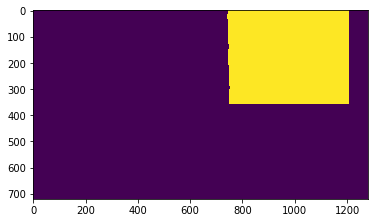

In [107]:
img_path = SAVE_DIR + '/table.png'
depth_img, lines, plane_est = line_detect(img_path)

In [88]:
def similarity2line1(u_j, v_j, u_list, v_list):
    u1 = u_list[0]
    u2 = u_list[1]
    v1 = v_list[0]
    v2 = v_list[1]
    value = float((v_j-v1)*(u2-u1) - (v2-v1)*(u_j-u1))
    print(value)
    return abs(value)

In [89]:
def similarity2line2(u_j, v_j, u_list, v_list):
    u1 = u_list[0]
    u3 = u_list[2]
    v1 = v_list[0]
    v3 = v_list[2]
    value = float((v_j-v1)*(u3-u1) - (v3-v1)*(u_j-u1))
    print(value)
    return abs(value)

In [90]:
# 꼭짓점 4개의 좌표가 온다고 할 때,
# 아니다.사진 찍은 위치의 코너를 알고 있으면 좌표 세개로부터 직선 두개 결정
# stack하는 순서는 찍은 코너를 첫번째로 stacking
# point 3개가 넘어온다 생각하고, pixel 좌표로 변환한 거를 저장하는 u,v list

# test
# p1 = np.array([0.5,0.5,T_Depth])
# p2 = np.array([0.5,0.5+T_Width,T_Depth])
# p3 = np.array([0.5+T_Height,0.5,T_Depth])
# p = np.vstack([p1, p2, p3])
p = np.vstack([P_cam_c, P_cam_c_up, P_cam_c_right])
print(p)

[[ 0.          0.          0.49999997]
 [ 0.         -0.5550788   1.0550789 ]
 [ 1.8         0.          0.49999997]]


In [91]:
u_list

[351, 351, 2024]

In [80]:
v_list

[238, -5, 238]

In [81]:
model_depth = np.zeros((480, 640), np.uint8)

In [82]:
uvidx = 0
model_depth[v_list[uvidx]-10:v_list[uvidx]+10, u_list[uvidx]-10:u_list[uvidx]+10] = 255
uvidx = 1
model_depth[v_list[uvidx]-10:v_list[uvidx]+10, u_list[uvidx]-10:u_list[uvidx]+10] = 255

In [83]:
viewpoint.draw_traj_coords([gase_pose])

[array([[-5.82929676e-05, -7.07794631e-01,  7.06418279e-01,
          7.64002148e-02],
        [-1.00000000e+00,  1.62645705e-04,  8.04436940e-05,
          5.00030210e-01],
        [-1.71830599e-04, -7.06418253e-01, -7.07794604e-01,
          6.58541665e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])]

In [148]:
x1, y1, x2, y2 = lines[5][0]
similarity2line2(x1, y1, u_list, v_list)

-71939.0


71939.0

In [157]:
similarity2line2(x2, y2, u_list, v_list)

-235893.0


235893.0

In [87]:
similarity2line1

<function __main__.similarity2line1>

In [100]:
u_list

[351, 351, 2024]

In [101]:
v_list

[238, -5, 238]

In [102]:
lines

array([[[396, 204, 639, 204]],

       [[204, 205, 395, 205]],

       [[254,  95, 403, 100]],

       [[411, 102, 591, 109]],

       [[499, 104, 636, 109]],

       [[205, 195, 236,  97]]], dtype=int32)

In [129]:
index1

5

In [130]:
index2

5

In [131]:
lines[index1]

array([[205, 195, 236,  97]], dtype=int32)

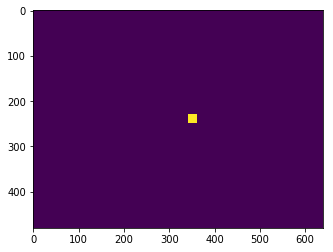

In [84]:
plt.imshow(model_depth)

In [116]:
np.mean(v_list[:2])+5

121.5

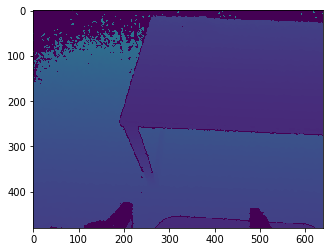

In [98]:
plt.imshow(depth_img)

In [238]:
mask = np.zeros((480,640,3), np.uint8)

In [239]:
# for il in range(len(lines)):
il = 1
masknew = cv2.line(mask, tuple(lines[il][0][:2]), tuple(lines[il][0][-2:]), (0,0,255), 2)

In [236]:
masknew = cv2.line(mask, (u_list[0], v_list[0]), (u_list[1], v_list[1]), (255,0,0), 2)

In [240]:
masknew = cv2.line(mask, (u_list[0], v_list[0]), (u_list[2], v_list[2]), (255,0,0), 2)

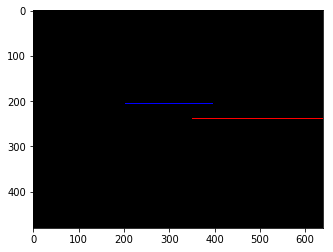

In [241]:
plt.imshow(masknew)

In [230]:
# def edge_detect(depth_img, p):
# Convert points w.r.t pixel coordinate

u_list = []
v_list = []
for i in range(3):
    u_list.append(int((p[i][0]/p[i][2]) * cam_intrins.fx + cam_intrins.ppx))
    v_list.append(int((p[i][1]/p[i][2]) * cam_intrins.fy + cam_intrins.ppy))

# Find similar lines
metric1 = []
metric2 = []
for i in lines:
    xe, ye, xs, ys = i[0][0], i[0][1], i[0][2], i[0][3]
    print(xe, ye, xs, ys)
    result1 = []
    result2 = []
#     dx = xe - xs 
#     dx_dir = np.sign(dx)
#     for u_j in range(np.abs(dx)):
#         v_j = (ye-ys)/(xe-xs) * (dx_dir*u_j-xs) + ys 
#         #u_j = int((xe-xs)/(ye-ys) * (v_j-ys) + xs)
#         print(u_j, v_j)
#         print(similarity2line1(u_j, v_j, u_list, v_list))
#         print(similarity2line1(u_j, v_j, u_list, v_list))
    result1.append(similarity2line1(xe, ye, u_list, v_list))
    result1.append(similarity2line1(xs, ys, u_list, v_list))
    result2.append(similarity2line2(xe, ye, u_list, v_list))
    result2.append(similarity2line2(xs, ys, u_list, v_list))

    print(result1)
    print(result2)
    metric1.append(np.mean(result1))
    metric2.append(np.mean(result2))

print(metric1)
print(metric2)
index1 = np.argmin(metric1)
index2 = np.argmin(metric2)

print(index1, index2)


# Start, End Points of lines
xe, ye, xs, ys = lines[index1][0]
xe_, ye_, xs_, ys_ = lines[index2][0]
#print(xe, ye, xs, ys)
#print(xe_, ye_, xs_, ys_)

# Two vectors which represent the line
z1 = (depth_img[ys][xs]/65535.0)/(d_scale*1000)
x1 = (xs - cam_intrins.ppx) * z1/cam_intrins.fx
y1 = (ys - cam_intrins.ppy) * z1/cam_intrins.fy
p1 = np.asmatrix(np.array([[x1],[y1],[z1]]))

z2 = (depth_img[ye][xe]/65535.0)/(d_scale*1000)
x2 = (xe - cam_intrins.ppx) * z2/cam_intrins.fx
y2 = (ye - cam_intrins.ppy) * z2/cam_intrins.fy
p2 = np.asmatrix(np.array([[x2],[y2],[z2]]))

z1_ = (depth_img[ys_][xs_]/65535.0)/(d_scale*1000)
x1_ = (xs_ - cam_intrins.ppx) * z1_/cam_intrins.fx
y1_ = (ys_ - cam_intrins.ppy) * z1_/cam_intrins.fy
p1_ = np.asmatrix(np.array([[x1_],[y1_],[z1_]]))

z2_ = (depth_img[ye_][xe_]/65535.0)/(d_scale*1000)
x2_ = (xs_ - cam_intrins.ppx) * z2_/cam_intrins.fx
y2_ = (ys_ - cam_intrins.ppy) * z2_/cam_intrins.fy
p2_ = np.asmatrix(np.array([[x2_],[y2_],[z2_]]))

line_vec1 = p2 - p1
line_vec2 = p2_ - p1_
ax_x = line_vec1
ax_y = line_vec2

# Detect Edge point of table
edge_cand1 = (p1+p1_)/2
edge_cand2 = (p1+p2_)/2
edge_cand3 = (p2+p1_)/2
edge_cand4 = (p2+p2_)/2

dist_cand1 = np.linalg.norm(p1 - p1_)
dist_cand2 = np.linalg.norm(p1 - p2_)
dist_cand3 = np.linalg.norm(p2 - p1_)
dist_cand4 = np.linalg.norm(p2 - p2_)

edge_list = [dist_cand1, dist_cand2, dist_cand3, dist_cand4]
idx = edge_list.index(min(edge_list)) + 1

edge = edge_cand4
if (idx == 1):
    edge = edge_cand1

if (idx == 2):
    edge = edge_cand2

if (idx == 3):
    edge = edge_cand3

if (idx == 4):
    edge = edge_cand4

# return edge, ax_x, ax_y

(396, 204, 639, 204)
10935.0
69984.0
-56882.0
-56882.0
[10935.0, 69984.0]
[56882.0, 56882.0]
(204, 205, 395, 205)
-35721.0
10692.0
-55209.0
-55209.0
[35721.0, 10692.0]
[55209.0, 55209.0]
(254, 95, 403, 100)
-23571.0
12636.0
-239239.0
-230874.0
[23571.0, 12636.0]
[239239.0, 230874.0]
(411, 102, 591, 109)
14580.0
58320.0
-227528.0
-215817.0
[14580.0, 58320.0]
[227528.0, 215817.0]
(499, 104, 636, 109)
35964.0
69255.0
-224182.0
-215817.0
[35964.0, 69255.0]
[224182.0, 215817.0]
(205, 195, 236, 97)
-35478.0
-27945.0
-71939.0
-235893.0
[35478.0, 27945.0]
[71939.0, 235893.0]
[40459.5, 23206.5, 18103.5, 36450.0, 52609.5, 31711.5]
[56882.0, 55209.0, 235056.5, 221672.5, 219999.5, 153916.0]
(2, 1)


In [105]:
edge

matrix([[-0.06066416],
        [-0.07450263],
        [ 0.24396123]])

In [231]:
index1

2

In [232]:
index2

1

In [96]:
lines[index1]

array([[396, 204, 639, 204]], dtype=int32)

In [97]:
lines[index2]

array([[204, 205, 395, 205]], dtype=int32)

In [ ]:
depth_img, lines, plane_est 

In [99]:
lines

array([[[396, 204, 639, 204]],

       [[204, 205, 395, 205]],

       [[254,  95, 403, 100]],

       [[411, 102, 591, 109]],

       [[499, 104, 636, 109]],

       [[205, 195, 236,  97]]], dtype=int32)

In [102]:
edge, ax_x, ax_y = edge_detect(depth_img, p)

(300, 205, 639, 205)
[]
[]
(246, 95, 403, 100)
[]
[]
(204, 206, 299, 206)
[]
[]
(289, 97, 331, 98)
[]
[]
(449, 104, 639, 108)
[]
[]
(413, 103, 591, 109)
[]
[]
(205, 196, 235, 97)
[]
[]
(204, 204, 236, 97)
[]
[]
[nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan]
(0, 0)


In [111]:
##### Testing용 #####
T_co_new = np.matmul(SE3_inv(T_bcam), T_bt)
######################

In [112]:
T_co_new

array([[-0.70710677,  0.        , -0.70710677, -0.01767766],
       [ 0.        ,  1.        ,  0.        , -0.9       ],
       [ 0.70710677,  0.        , -0.70710677,  1.0374011 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [115]:
def pose_obj(plane_model, edge, ax_x, ax_y, T_co_new):
    a, b, c, d = plane_model
    surface_normal = np.array([[a], [b], [c]])
    #surface_normal = np.cross(line_v1.T, line_v2.T) 

    # ax_x, ax_y가 line으로부터 땄는데, 반드시 수직하다는 보장 있나..? 근접샷에서 딴 거니까 정확하다고 그냥 생각해야하나
    # normalize 
    if (np.dot(T_co_new[0:3,0].T, ax_x) < 0):
        ax_x = -ax_x

    if (np.dot(T_co_new[0:3,1].T, ax_y) < 0):
        ax_y = -ax_y

    ax_z = surface_normal/np.linalg.norm(surface_normal)
    ax_x = ax_x/np.linalg.norm(ax_x)
    ax_y = ax_y/np.linalg.norm(ax_y)
    #print(np.dot(ax_z.T,ax_x))
    #print(np.dot(ax_x.T,ax_y))
    #print(np.dot(ax_y.T,ax_z))


    # Estimated Orientation of table from camera coordinate
    model_rotation_mtx = np.hstack([ax_x, ax_y, ax_z])

    #estimated_box = o3d.geometry.TriangleMesh.create_box(width=T_Width, height=T_Height, depth=T_Depth)
    #estimated_box.translate(edge)
    #estimated_box.rotate(model_rotation_mtx)
    FOR_box = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
    FOR_box.translate(edge)
    FOR_box.rotate(model_rotation_mtx)
    #FOR_box.translate((-T_Height/2, T_Width/2, -T_Depth/2), relative=True)

    T_co_result = np.identity(4)
    T_co_result[0:3,0:3] = model_rotation_mtx
    T_co_result[0:3,3] = FOR_box.get_center().T
    #model_new_center = (T_co_new[0:3,3] + FOR_box.get_center())/2

    print("\nHomogeneous Transformation(Cam to Table) is :")
    print(T_co_result)
    return T_co_result

In [116]:
T_co_result = pose_obj(plane_est, edge, ax_x, ax_y, T_co_new)


Homogeneous Transformation(Cam to Table) is :
[[-0.99947515 -0.52518796 -0.02611748 -0.33510759]
 [ 0.00228667  0.06188641  0.62231477  0.89366705]
 [-0.03231415 -0.84873298  0.78233127 -0.16320077]
 [ 0.          0.          0.          1.        ]]
